In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.5)
sns.set_palette("Dark2")

results = pd.read_parquet("./sampling_scaling_rtt.gzip")

# only look at the empirical-high timing model (ground truth)
results = results[results["timing_model"] == "empirical-high"].copy()
results["timing_model"] = results["timing_model"].cat.remove_unused_categories()


def _classify_sampling(s: str) -> str:
    ssplit = s.split("-")
    if len(ssplit) > 1:
        if ssplit[0] == "adaptive":
            if ssplit[1] == "power":
                return "adaptive-energy"
            else:
                return "adaptive-ttf"
        return ssplit[0]
    else:
        return "reference"


results["sampling_class"] = (
    results["sampling_scheme"]
    .apply(_classify_sampling)
    .astype(pd.CategoricalDtype(["adaptive-energy", "adaptive-ttf", "reference", "periodic", "hold"]))
)

included_schemes = ['greedy',
 'ideal',
 'adaptive-power-empirical',
 'adaptive-power-empirical-low',
 'adaptive-power-empirical-high',
 'adaptive-power-theoretical-exgaussian',
 'adaptive-power-theoretical-exgaussian-low',
 'adaptive-power-theoretical-exgaussian-high',
 'adaptive-power-fitted-naive-exgaussian',
 'periodic-0.1s',
 'periodic-0.2s',
 'periodic-0.5s',
 'periodic-1.0s',
 'hold-3.0s',
 'hold-5.0s',
 'hold-7.0s']

results = results[np.isin(results["sampling_scheme"], included_schemes)]
results["sampling_scheme"] = results["sampling_scheme"].astype(pd.CategoricalDtype(included_schemes, ordered=True))
results["success_sample_instant"] = results["execution_time"] + results["wait_time"]

results

,rtt,step,previous_ttf,execution_time,step_duration,ttf,wait_time,samples,cumulative_duration,cumulative_samples,...,energy,cumulative_energy,comm_time,idle_time,comm_energy,idle_energy,timing_model,sampling_scheme,sampling_class,success_sample_instant
0,0.5,1,0.500000,3.240212,18.389461,15.149249,14.649249,1,18.389461,1,...,1.172842,1.172842,0.2,18.189461,0.90,0.272842,empirical-high,adaptive-power-empirical-high,adaptive-energy,17.889461
1,0.5,2,15.149249,6.637604,19.292436,12.654832,12.154832,1,37.681896,2,...,1.186387,2.359228,0.2,19.092436,0.90,0.286387,empirical-high,adaptive-power-empirical-high,adaptive-energy,18.792436
2,0.5,3,12.654832,5.210682,19.292436,14.081754,13.581754,1,56.974332,3,...,1.186387,3.545615,0.2,19.092436,0.90,0.286387,empirical-high,adaptive-power-empirical-high,adaptive-energy,18.792436
3,0.5,4,14.081754,6.379363,19.292436,12.913073,12.413073,1,76.266768,4,...,1.186387,4.732002,0.2,19.092436,0.90,0.286387,empirical-high,adaptive-power-empirical-high,adaptive-energy,18.792436
4,0.5,5,12.913073,4.258477,19.292436,15.033958,14.533958,1,95.559203,5,...,1.186387,5.918388,0.2,19.092436,0.90,0.286387,empirical-high,adaptive-power-empirical-high,adaptive-energy,18.792436
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1151995,1.0,116,1.916716,4.991266,6.000000,1.008734,0.008734,5,817.000000,701,...,15.787500,2213.044500,3.5,2.500000,15.75,0.037500,empirical-high,periodic-1.0s,periodic,5.000000
1151996,1.0,117,1.008734,5.950609,7.000000,1.049391,0.049391,6,824.000000,707,...,18.942000,2231.986500,4.2,2.800000,18.90,0.042000,empirical-high,periodic-1.0s,periodic,6.000000
1151997,1.0,118,1.049391,9.426369,11.000000,1.573631,0.573631,10,835.000000,717,...,31.560000,2263.546500,7.0,4.000000,31.50,0.060000,empirical-high,periodic-1.0s,periodic,10.000000
1151998,1.0,119,1.573631,3.093691,5.000000,1.906309,0.906309,4,840.000000,721,...,12.633000,2276.179500,2.8,2.200000,12.60,0.033000,empirical-high,periodic-1.0s,periodic,4.000000


In [2]:
power_consts = {
    # "comm": 0.045,
    "comm": 0.045,
    "idle": 0.015
}  # Watts

mean_power = (
    results.groupby(["sampling_class", "sampling_scheme", "rtt", "repetition"], observed=True)
    [["samples", "idle_time", "comm_time", "step_duration"]]
    .sum()
    .reset_index()
    .copy()
)
mean_power["comm_time"] = mean_power["samples"] * (mean_power["rtt"] - 0.3)
mean_power["comm_energy"] = mean_power["comm_time"] * power_consts["comm"]
mean_power["idle_time"] = mean_power["step_duration"] - mean_power["comm_time"]
mean_power["idle_energy"] = mean_power["idle_time"] * power_consts["idle"]

mean_power["total_energy"] = mean_power["idle_energy"] + mean_power["comm_energy"]
mean_power["power"] = mean_power["total_energy"] / mean_power["step_duration"]
mean_power

,sampling_class,sampling_scheme,rtt,repetition,samples,idle_time,comm_time,step_duration,comm_energy,idle_energy,total_energy,power
0,adaptive-energy,adaptive-power-empirical,0.5,1,127,2455.245153,25.4,2480.645153,1.1430,36.828677,37.971677,0.015307
1,adaptive-energy,adaptive-power-empirical,0.5,2,121,2392.923407,24.2,2417.123407,1.0890,35.893851,36.982851,0.015300
2,adaptive-energy,adaptive-power-empirical,0.5,3,125,2410.687685,25.0,2435.687685,1.1250,36.160315,37.285315,0.015308
3,adaptive-energy,adaptive-power-empirical,0.5,4,122,2415.671929,24.4,2440.071929,1.0980,36.235079,37.333079,0.015300
4,adaptive-energy,adaptive-power-empirical,0.5,5,123,2391.974806,24.6,2416.574806,1.1070,35.879622,36.986622,0.015305
...,...,...,...,...,...,...,...,...,...,...,...,...
9595,periodic,periodic-1.0s,5.0,56,321,216.300000,1508.7,1725.000000,67.8915,3.244500,71.136000,0.041238
9596,periodic,periodic-1.0s,5.0,57,334,220.200000,1569.8,1790.000000,70.6410,3.303000,73.944000,0.041309
9597,periodic,periodic-1.0s,5.0,58,325,217.500000,1527.5,1745.000000,68.7375,3.262500,72.000000,0.041261
9598,periodic,periodic-1.0s,5.0,59,358,227.400000,1682.6,1910.000000,75.7170,3.411000,79.128000,0.041428


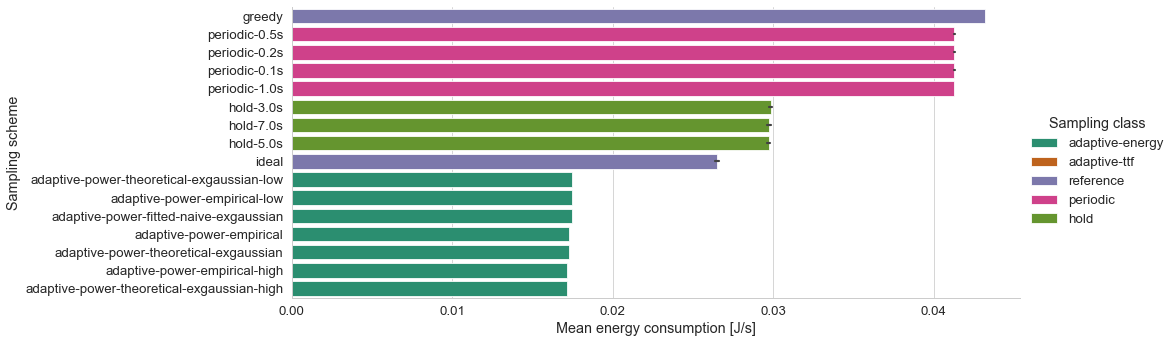

count      mean  \
sampling_class  sampling_scheme                                               
reference       greedy                                       60.0  0.043200   
periodic        periodic-0.5s                                60.0  0.041296   
                periodic-0.2s                                60.0  0.041293   
                periodic-0.1s                                60.0  0.041292   
                periodic-1.0s                                60.0  0.041288   
hold            hold-3.0s                                    60.0  0.029850   
                hold-7.0s                                    60.0  0.029758   
                hold-5.0s                                    60.0  0.029717   
reference       ideal                                        60.0  0.026499   
adaptive-energy adaptive-power-theoretical-exgaussian-low    60.0  0.017495   
                adaptive-power-empirical-low                 60.0  0.017495   
                adaptive-power-fitted-naive-exgaussian       60.0  0.017491   
                adaptive-power-empirical                     60.0  0.017292   
                adaptive-power-theoretical-exgaussian        60.0  0.017292   
                adaptive-power-empirical-high                60.0  0.017182   
                adaptive-power-theoretical-exgaussian-high   60.0  0.017182   

                                                                     std  \
sampling_class  sampling_scheme                                            
reference       greedy                                      1.061216e-17   
periodic        periodic-0.5s                               7.401949e-05   
                periodic-0.2s                               5.356146e-05   
                periodic-0.1s                               5.939579e-05   
                periodic-1.0s                               6.464201e-05   
hold            hold-3.0s                                   4.212604e-04   
                hold-7.0s                                   4.133047e-04   
                hold-5.0s                                   3.748469e-04   
reference       ideal                                       4.460405e-04   
adaptive-energy adaptive-power-theoretical-exgaussian-low   1.230456e-06   
                adaptive-power-empirical-low                3.498726e-18   
                adaptive-power-fitted-naive-exgaussian      1.737383e-06   
                adaptive-power-empirical                    1.216224e-06   
                adaptive-power-theoretical-exgaussian       3.498726e-18   
                adaptive-power-empirical-high               1.193975e-06   
                adaptive-power-theoretical-exgaussian-high  0.000000e+00   

                                                                 min  \
sampling_class  sampling_scheme                                        
reference       greedy                                      0.043200   
periodic        periodic-0.5s                               0.041124   
                periodic-0.2s                               0.041186   
                periodic-0.1s                               0.041143   
                periodic-1.0s                               0.041155   
hold            hold-3.0s                                   0.028887   
                hold-7.0s                                   0.028844   
                hold-5.0s                                   0.028712   
reference       ideal                                       0.025489   
adaptive-energy adaptive-power-theoretical-exgaussian-low   0.017495   
                adaptive-power-empirical-low                0.017495   
                adaptive-power-fitted-naive-exgaussian      0.017491   
                adaptive-power-empirical                    0.017292   
                adaptive-power-theoretical-exgaussian       0.017292   
                adaptive-power-empirical-high               0.017182   
                adaptive-power-theoretical-e

In [3]:
power_max_rtt = mean_power[mean_power["rtt"] == mean_power["rtt"].max()]
mean_power_max_rtt = (
    power_max_rtt
    .groupby(["sampling_class", "sampling_scheme"], observed=True)
    ["power"]
    .describe()
    .sort_values("mean", ascending=False)
)

fg = sns.catplot(
    kind="bar",
    errorbar=("ci", 95),
    data=power_max_rtt,
    x="power",
    y="sampling_scheme",
    order=mean_power_max_rtt.index.get_level_values(1),
    hue="sampling_class",
    aspect=3,
    dodge=False,
)
fg.set_axis_labels("Mean energy consumption [J/s]", "Sampling scheme")
fg.legend.set_title("Sampling class")
plt.show()

mean_power_max_rtt

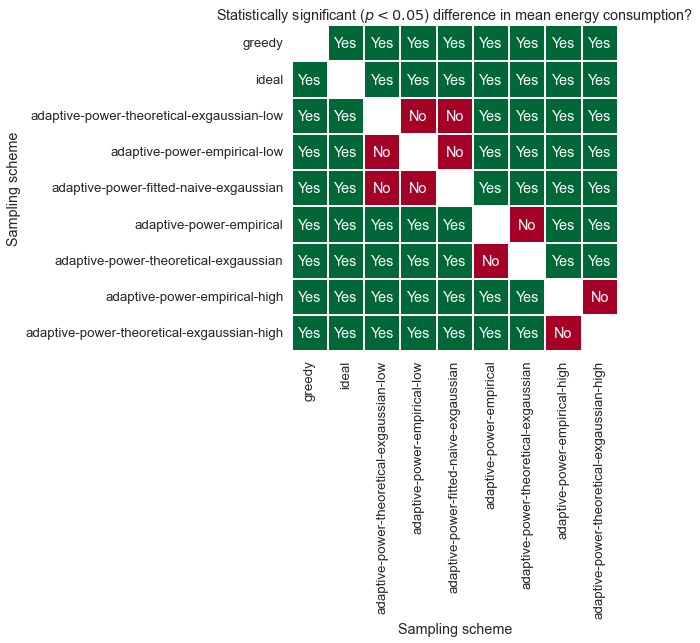

In [4]:
import scipy.stats as stats
import itertools as it

relevant_schemes = mean_power_max_rtt.loc[["reference", "adaptive-energy"], :].sort_values("mean", ascending=False).index.get_level_values(1)

p_values = pd.DataFrame(index=relevant_schemes, columns=relevant_schemes, dtype=float)
for row, col in it.product(p_values.index, p_values.columns):
    if row == col:
        continue
    t_stat, p_val = stats.ttest_ind(
        mean_power.loc[mean_power["sampling_scheme"] == row, "power"].to_numpy(),
        mean_power.loc[mean_power["sampling_scheme"] == col, "power"].to_numpy(),
        alternative="two-sided",
        # null-hypothesis is that energies have the same mean and that the observed difference is just random
    )
    p_values.at[row, col] = p_val

significant = p_values < 0.05
significant[p_values.isna()] = np.NaN
for c in significant.columns:
    significant[c] = significant[c].astype(float)

fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.heatmap(
    significant,
    square=True,
    annot=significant.applymap(lambda e: "Yes" if e > 0.5 else "No"),
    fmt="",
    # center=0.05,
    cbar=False,
    cmap="RdYlGn",
    linewidths=2,
    ax=ax,
)
ax.set_title("Statistically significant ($p < 0.05$) difference in mean energy consumption?")
ax.set_xlabel("Sampling scheme")
ax.set_ylabel("Sampling scheme")
plt.show()

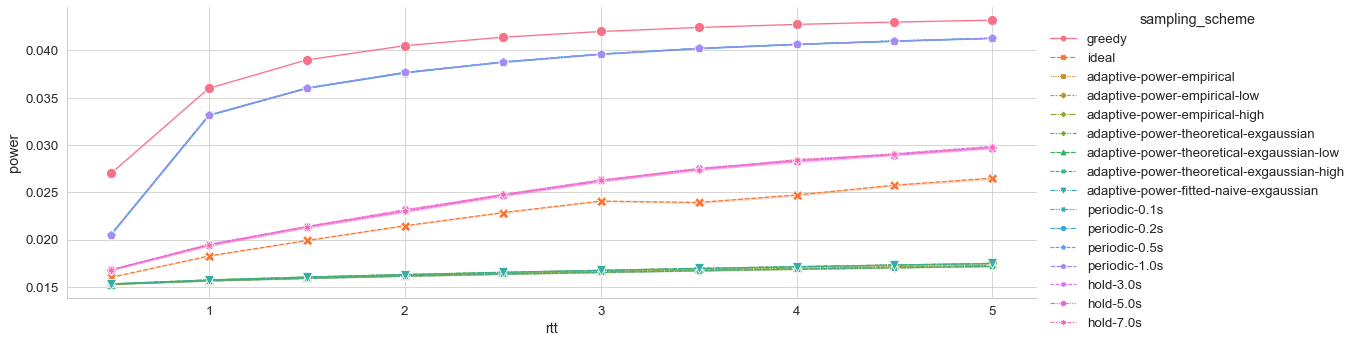

In [5]:
fg = sns.relplot(
    kind="line",
    data=mean_power,
    x="rtt",
    y="power",
    style="sampling_scheme",
    hue="sampling_scheme",
    markers=True,
    aspect=3,
    markersize=10,
)
plt.show()

In [6]:
results_per_rep = (
    results
    .groupby(["timing_model", "sampling_scheme", "sampling_class", "rtt", "repetition"], observed=True)
    [["execution_time", "step_duration", "ttf", "wait_time", "samples", "energy", "idle_energy", "comm_energy", "idle_time", "comm_time", "success_sample_instant"]]
    .mean()
    .reset_index()
)
results_per_rep

,timing_model,sampling_scheme,sampling_class,rtt,repetition,execution_time,step_duration,ttf,wait_time,samples,energy,idle_energy,comm_energy,idle_time,comm_time,success_sample_instant
0,empirical-high,greedy,reference,0.5,1,5.407782,6.116667,0.708885,0.208885,12.233333,11.065050,0.055050,11.01000,3.6700,2.446667,5.616667
1,empirical-high,greedy,reference,0.5,2,5.284011,6.029167,0.745155,0.245155,12.058333,10.906763,0.054262,10.85250,3.6175,2.411667,5.529167
2,empirical-high,greedy,reference,0.5,3,5.506328,6.229167,0.722839,0.222839,12.458333,11.268562,0.056062,11.21250,3.7375,2.491667,5.729167
3,empirical-high,greedy,reference,0.5,4,5.182280,5.904167,0.721887,0.221887,11.808333,10.680637,0.053137,10.62750,3.5425,2.361667,5.404167
4,empirical-high,greedy,reference,0.5,5,5.464687,6.195833,0.731146,0.231146,12.391667,11.208263,0.055762,11.15250,3.7175,2.478333,5.695833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9595,empirical-high,hold-7.0s,hold,5.0,56,7.542670,15.208333,7.665664,2.665664,1.641667,34.833638,0.112388,34.72125,7.4925,7.715833,10.208333
9596,empirical-high,hold-7.0s,hold,5.0,57,8.120202,15.625000,7.504798,2.504798,1.725000,36.596513,0.112763,36.48375,7.5175,8.107500,10.625000
9597,empirical-high,hold-7.0s,hold,5.0,58,7.173947,14.625000,7.451053,2.451053,1.525000,32.365613,0.111862,32.25375,7.4575,7.167500,9.625000
9598,empirical-high,hold-7.0s,hold,5.0,59,7.310485,14.708333,7.397849,2.397849,1.541667,32.718188,0.111937,32.60625,7.4625,7.245833,9.708333


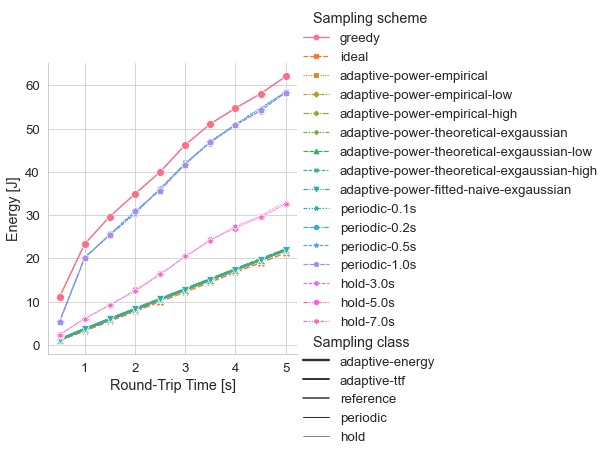

In [7]:
fg = sns.relplot(
    kind="line",
    errorbar=None,
    data=results_per_rep.rename(columns={"sampling_scheme": "Sampling scheme", "sampling_class": "Sampling class"}),
    x="rtt",
    y="energy",
    hue="Sampling scheme",
    style="Sampling scheme",
    size="Sampling class",
    markers=True,
    aspect=1,
    markersize=8,
)
fg.set_axis_labels("Round-Trip Time [s]", "Energy [J]")
# fg.legend.set_title("Sampling Scheme")
plt.show()

In [8]:
energy_at_max_rtt = (
    results_per_rep[results_per_rep["rtt"] == results_per_rep["rtt"].max()]
    .groupby("sampling_scheme")
    ["energy"]
    .mean()
    .sort_values()
)
energy_at_max_rtt

sampling_scheme
ideal                                         21.263700
adaptive-power-empirical-low                  21.927162
adaptive-power-theoretical-exgaussian-low     21.930151
adaptive-power-fitted-naive-exgaussian        21.934649
adaptive-power-theoretical-exgaussian         22.002438
adaptive-power-empirical                      22.005429
adaptive-power-theoretical-exgaussian-high    22.048830
adaptive-power-empirical-high                 22.051824
hold-5.0s                                     32.477261
hold-7.0s                                     32.679992
hold-3.0s                                     33.111896
periodic-1.0s                                 58.245699
periodic-0.1s                                 58.360286
periodic-0.2s                                 58.383791
periodic-0.5s                                 58.551264
greedy                                        62.050262
Name: energy, dtype: float64

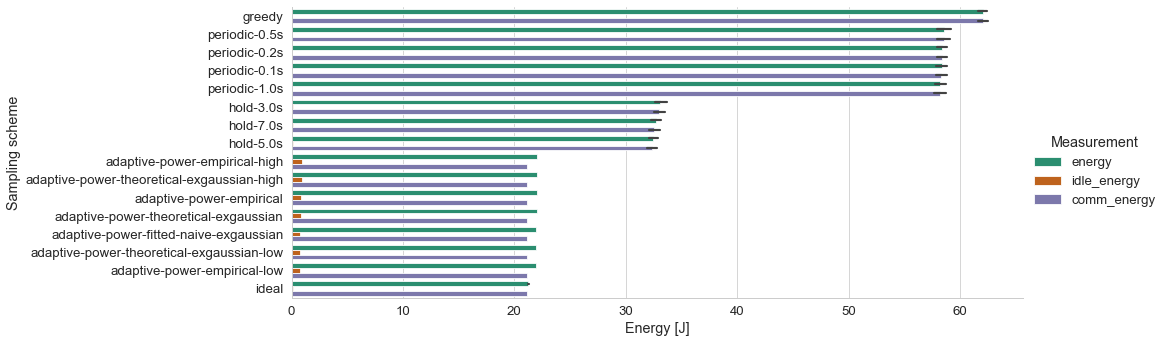

In [9]:
fg = sns.catplot(
    kind="bar",
    errorbar=("ci", 95),
    data=(
        results_per_rep[results_per_rep["rtt"] == results_per_rep["rtt"].max()]
        [["sampling_scheme", "energy", "idle_energy", "comm_energy"]]
        .set_index("sampling_scheme")
        .stack()
        .reset_index()
        .rename(columns={"level_1": "energy", 0: "value"})
    ),
    y="sampling_scheme",
    order=reversed(energy_at_max_rtt.index),
    x="value",
    # join=False,
    hue="energy",
    # hue_order=["adaptive-energy", "adaptive-ttf", "periodic", "hold", "reference"],
    aspect=3,
    # markers="+",
    dodge=True,
)
# for ax in fg.axes.flat:
#     ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=55, ha="right", rotation_mode="anchor")

fg.set_axis_labels("Energy [J]", "Sampling scheme")
fg.legend.set_title("Measurement")
# fg.set(xscale="log", xlim=(0.1, 10))
plt.show()

/Users/molguin/.venvs/EdgeDroid/lib/python3.10/site-packages/seaborn/categorical.py:1727: UserWarning: You passed a edgecolor/edgecolors ((0.10588235294117647, 0.6196078431372549, 0.4666666666666667)) for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
/Users/molguin/.venvs/EdgeDroid/lib/python3.10/site-packages/seaborn/categorical.py:1727: UserWarning: You passed a edgecolor/edgecolors ((0.8509803921568627, 0.37254901960784315, 0.00784313725490196)) for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
/Users/molguin/.venvs/EdgeDroid/lib/python3.10/site-packages/seaborn/categorical.py:1727: UserWarning: You passed a edgecolor/edgecolors ((0.4588235294117647, 0.4392156862745098, 0.7019607843137254)) for an unfilled marker ('+').  Matplotlib is ignoring

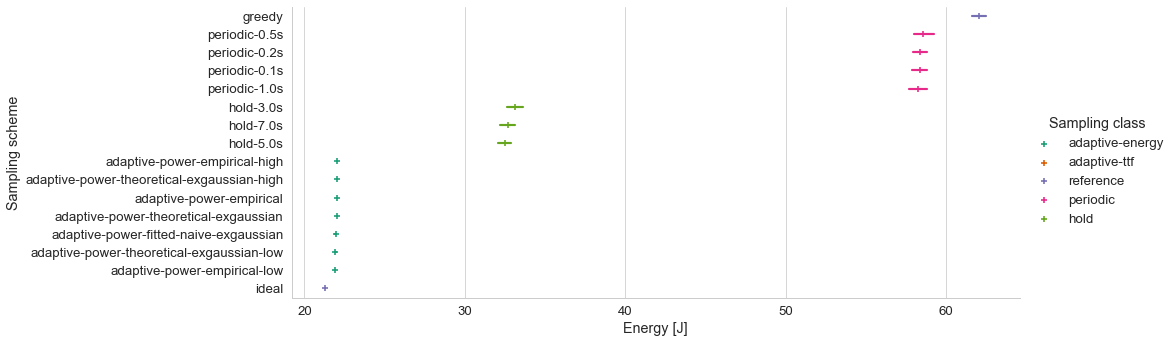

In [10]:
fg = sns.catplot(
    kind="point",
    errorbar=("ci", 95),
    data=results_per_rep[results_per_rep["rtt"] == results_per_rep["rtt"].max()],
    y="sampling_scheme",
    order=reversed(energy_at_max_rtt.index),
    x="energy",
    join=False,
    hue="sampling_class",
    # hue_order=["adaptive-energy", "adaptive-ttf", "periodic", "hold", "reference"],
    aspect=3,
    markers="+",
)
# for ax in fg.axes.flat:
#     ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=55, ha="right", rotation_mode="anchor")

fg.set_axis_labels("Energy [J]", "Sampling scheme")
fg.legend.set_title("Sampling class")
# fg.set(xscale="log", xlim=(0.1, 10))
plt.show()

test if difference between mean energies at max rtt is statistically significant!
null hypothesis is that all sampling schemes have the same mean

In [11]:
import scipy.stats as stats

# import itertools as it

energies = (
    results_per_rep
    .loc[(results_per_rep["rtt"] == results_per_rep["rtt"].max())]
    .copy()
)

p_values = pd.DataFrame(index=included_schemes, columns=included_schemes, dtype=float)
cols = set(included_schemes)
last_row = len(included_schemes)
for row in included_schemes:
    for col in cols:
        if row == col:
            continue
        t_stat, p_val = stats.ttest_ind(
            energies.loc[energies["sampling_scheme"] == row, "energy"].to_numpy(),
            energies.loc[energies["sampling_scheme"] == col, "energy"].to_numpy(),
            alternative="two-sided",
            # null-hypothesis is that energies have the same mean and that the observed difference is just random
        )
        p_values.at[row, col] = p_val

    # cols.remove(row)
p_values.style.format(lambda e: "p < 0.05" if e < 0.05 else "Not significant")

/var/folders/m2/92s4j7tx64b5y7_fxzjwmp2m0000gn/T/ipykernel_64659/2145193143.py:18: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t_stat, p_val = stats.ttest_ind(


,greedy,ideal,adaptive-power-empirical,adaptive-power-empirical-low,adaptive-power-empirical-high,adaptive-power-theoretical-exgaussian,adaptive-power-theoretical-exgaussian-low,adaptive-power-theoretical-exgaussian-high,adaptive-power-fitted-naive-exgaussian,periodic-0.1s,periodic-0.2s,periodic-0.5s,periodic-1.0s,hold-3.0s,hold-5.0s,hold-7.0s
greedy,Not significant,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05
ideal,p < 0.05,Not significant,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05
adaptive-power-empirical,p < 0.05,p < 0.05,Not significant,p < 0.05,p < 0.05,Not significant,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05
adaptive-power-empirical-low,p < 0.05,p < 0.05,p < 0.05,Not significant,p < 0.05,p < 0.05,Not significant,p < 0.05,Not significant,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05
adaptive-power-empirical-high,p < 0.05,p < 0.05,p < 0.05,p < 0.05,Not significant,p < 0.05,p < 0.05,Not significant,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05
adaptive-power-theoretical-exgaussian,p < 0.05,p < 0.05,Not significant,p < 0.05,p < 0.05,Not significant,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05
adaptive-power-theoretical-exgaussian-low,p < 0.05,p < 0.05,p < 0.05,Not significant,p < 0.05,p < 0.05,Not significant,p < 0.05,Not significant,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05
adaptive-power-theoretical-exgaussian-high,p < 0.05,p < 0.05,p < 0.05,p < 0.05,Not significant,p < 0.05,p < 0.05,Not significant,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05
adaptive-power-fitted-naive-exgaussian,p < 0.05,p < 0.05,p < 0.05,Not significant,p < 0.05,p < 0.05,Not significant,p < 0.05,Not significant,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05
periodic-0.1s,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,p < 0.05,Not significant,Not significant,Not significant,Not significant,p < 0.05,p < 0.05,p < 0.05


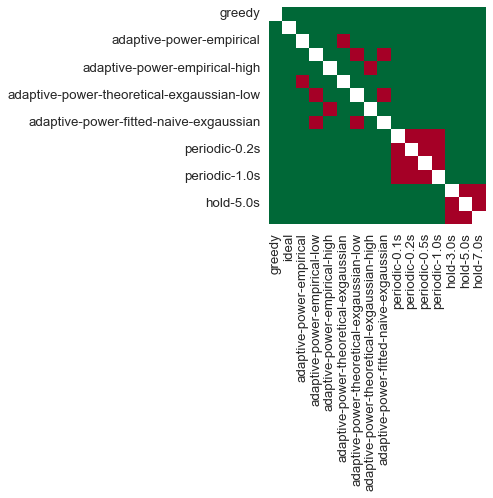

In [12]:
significant = p_values < 0.05
significant[p_values.isna()] = np.NaN
for c in significant.columns:
    significant[c] = significant[c].astype(float)

ax = sns.heatmap(
    significant,
    square=True,
    # annot=True,
    # center=0.05,
    cbar=False,
    cmap="RdYlGn",
)
plt.show()


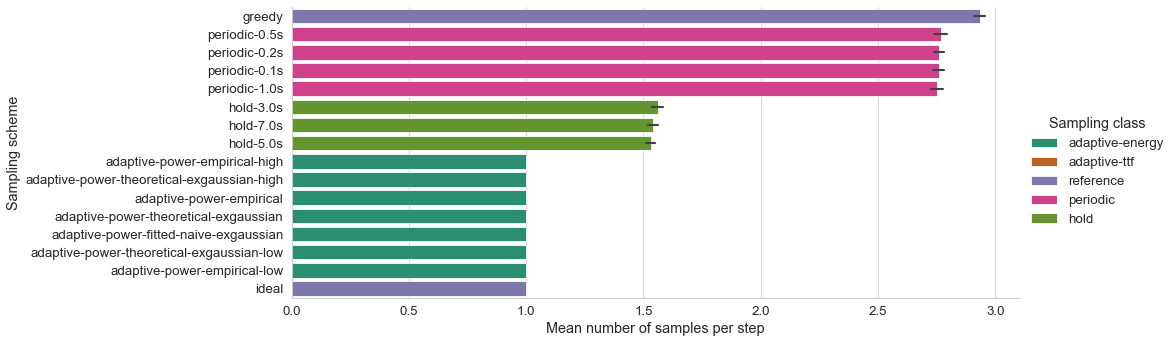

In [13]:
fg = sns.catplot(
    kind="bar",
    errorbar=("ci", 95),
    data=results_per_rep[results_per_rep["rtt"] == results_per_rep["rtt"].max()],
    y="sampling_scheme",
    order=reversed(energy_at_max_rtt.index),
    x="samples",
    # join=False,
    hue="sampling_class",
    # hue_order=["adaptive-energy", "adaptive-ttf", "periodic", "hold", "reference"],
    aspect=3,
    # markers="+",
    dodge=False,
)
# for ax in fg.axes.flat:
#     ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=55, ha="right", rotation_mode="anchor")

fg.set_axis_labels("Mean number of samples per step", "Sampling scheme")
fg.legend.set_title("Sampling class")
# fg.set(xscale="log", xlim=(0.1, 10))
plt.show()

In [14]:
(
    results[results["rtt"] == results["rtt"].max()]
    .groupby("sampling_scheme")
    ["samples"]
    .value_counts()
    .loc[pd.IndexSlice["adaptive-power-empirical-high"], :]
    .to_frame()
    .rename(columns={"samples": "counts"})
    .reset_index()
    .sort_values("samples")
)

,samples,counts
0,1,7199
1,2,1


In [15]:
(
    results[results["rtt"] == results["rtt"].max()]
    .groupby(["sampling_scheme", "samples"], observed=True)
    ["wait_time"]
    .describe()
    .loc["adaptive-power-empirical-high", :]
)

,count,mean,std,min,25%,50%,75%,max
samples,,,,,,,,
1,7199.0,52.399007,4.638375,11.188910,50.937365,53.317174,55.110297,58.215663
2,1.0,29.283283,NaN,29.283283,29.283283,29.283283,29.283283,29.283283


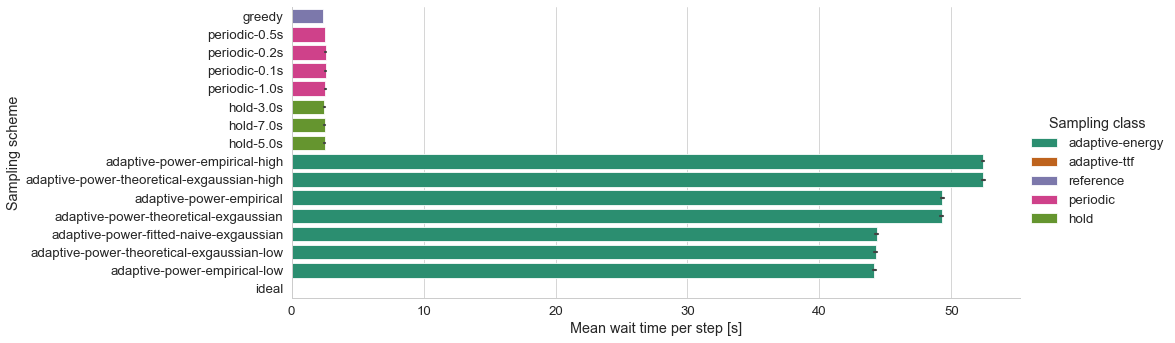

In [16]:
fg = sns.catplot(
    kind="bar",
    errorbar=("ci", 95),
    data=results_per_rep[results_per_rep["rtt"] == results_per_rep["rtt"].max()],
    y="sampling_scheme",
    order=reversed(energy_at_max_rtt.index),
    x="wait_time",
    # join=False,
    hue="sampling_class",
    # hue_order=["adaptive-energy", "adaptive-ttf", "periodic", "hold", "reference"],
    aspect=3,
    # markers="+",
    dodge=False,
)
# for ax in fg.axes.flat:
#     ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=55, ha="right", rotation_mode="anchor")

fg.set_axis_labels("Mean wait time per step [s]", "Sampling scheme")
fg.legend.set_title("Sampling class")
# fg.set(xscale="log", xlim=(0.1, 10))
plt.show()

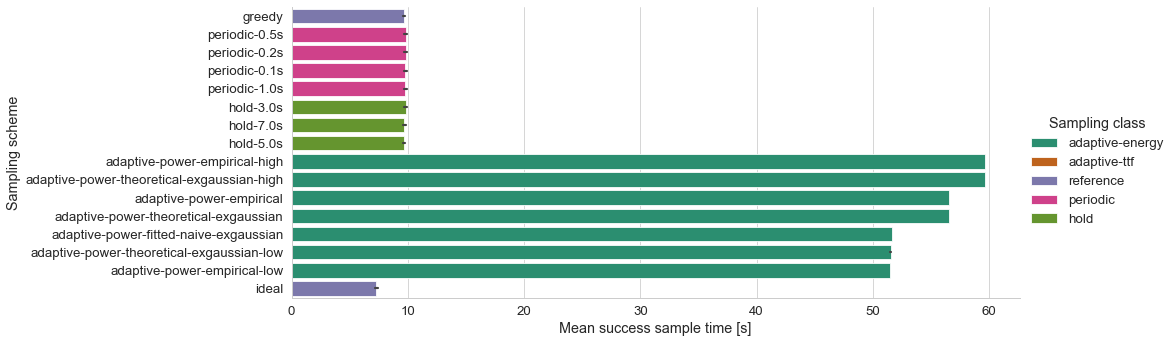

In [17]:
fg = sns.catplot(
    kind="bar",
    errorbar=("ci", 95),
    data=results_per_rep[results_per_rep["rtt"] == results_per_rep["rtt"].max()],
    y="sampling_scheme",
    order=reversed(energy_at_max_rtt.index),
    x="success_sample_instant",
    # join=False,
    hue="sampling_class",
    # hue_order=["adaptive-energy", "adaptive-ttf", "periodic", "hold", "reference"],
    aspect=3,
    # markers="+",
    dodge=False,
)
# for ax in fg.axes.flat:
#     ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=55, ha="right", rotation_mode="anchor")

fg.set_axis_labels("Mean success sample time [s]", "Sampling scheme")
fg.legend.set_title("Sampling class")
# fg.set(xscale="log", xlim=(0.1, 10))
plt.show()

In [18]:
energies_maxrtt = results_per_rep.loc[(results_per_rep["rtt"] == results_per_rep["rtt"].max())].groupby(
    ["sampling_class", "sampling_scheme"])["energy"].describe(percentiles=[])
energies_maxrtt["var"] = np.square(energies_maxrtt["std"])
energies_maxrtt

count       mean  \
sampling_class  sampling_scheme                                                
adaptive-energy adaptive-power-empirical                     60.0  22.005429   
                adaptive-power-empirical-low                 60.0  21.927162   
                adaptive-power-empirical-high                60.0  22.051824   
                adaptive-power-theoretical-exgaussian        60.0  22.002438   
                adaptive-power-theoretical-exgaussian-low    60.0  21.930151   
                adaptive-power-theoretical-exgaussian-high   60.0  22.048830   
                adaptive-power-fitted-naive-exgaussian       60.0  21.934649   
reference       greedy                                       60.0  62.050262   
                ideal                                        60.0  21.263700   
periodic        periodic-0.1s                                60.0  58.360286   
                periodic-0.2s                                60.0  58.383791   
                periodic-0.5s                                60.0  58.551264   
                periodic-1.0s                                60.0  58.245699   
hold            hold-3.0s                                    60.0  33.111896   
                hold-5.0s                                    60.0  32.477261   
                hold-7.0s                                    60.0  32.679992   

                                                                     std  \
sampling_class  sampling_scheme                                            
adaptive-energy adaptive-power-empirical                    2.317896e-02   
                adaptive-power-empirical-low                3.582695e-15   
                adaptive-power-empirical-high               2.318817e-02   
                adaptive-power-theoretical-exgaussian       1.074808e-14   
                adaptive-power-theoretical-exgaussian-low   2.316997e-02   
                adaptive-power-theoretical-exgaussian-high  0.000000e+00   
                adaptive-power-fitted-naive-exgaussian      3.248447e-02   
reference       greedy                                      1.862117e+00   
                ideal                                       7.187872e-03   
periodic        periodic-0.1s                               1.944985e+00   
                periodic-0.2s                               1.804717e+00   
                periodic-0.5s                               2.455277e+00   
                periodic-1.0s                               2.132189e+00   
hold            hold-3.0s                                   2.011916e+00   
                hold-5.0s                                   1.716541e+00   
                hold-7.0s                                   1.900086e+00   

                                                                  min  \
sampling_class  sampling_scheme                                         
adaptive-energy adaptive-power-empirical                    22.002436   
                adaptive-power-empirical-low                21.927162   
                adaptive-power-empirical-high               22.048830   
                adaptive-power-theoretical-exgaussian       22.002438   
                adaptive-power-theoretical-exgaussian-low   21.927159   
                adaptive-power-theoretical-exgaussian-high  22.048830   
                adaptive-power-fitted-naive-exgaussian      21.928668   
reference       greedy                                      58.527450   
                ideal                                       21.250156   
periodic        periodic-0.1s                               53.782688   
                periodic-0.2s                               55.016700   
                periodic-0.5s                               53.253825   
                periodic-1.0s                               54.135263   
hold            hold-3.0s                                   28.839863   
                hold-5.0s                                   28.134713   
         

In [19]:
import scipy.stats as stats

ix = pd.IndexSlice

# calculate the 95% CI for the difference between the means wrt to the ideal case
ideal_mean = energies_maxrtt.loc[ix["reference", "ideal"], "mean"]
ideal_var = energies_maxrtt.loc[ix["reference", "ideal"], "var"]
sample_size = results[(results["rtt"] == results["rtt"].max())].groupby("sampling_scheme").size().unique().take(0)

mean_diff = energies_maxrtt["mean"] - ideal_mean
t_critical = stats.t.ppf(q=0.95, df=sample_size + sample_size - 2)
spooled_variance = (((sample_size - 1) * np.square(energies_maxrtt["var"])) + (
            (sample_size - 1) * np.square(ideal_var))) / (sample_size + sample_size - 2)

t_factor = t_critical * np.sqrt(2 * np.square(spooled_variance) / sample_size)

energies_maxrtt["mean_diff_ideal"] = mean_diff
energies_maxrtt["mean_diff_ideal_95ci"] = t_factor

energies_maxrtt["mean_diff_ideal_percent"] = mean_diff / ideal_mean
energies_maxrtt["mean_diff_ideal_95ci_percent"] = t_factor / ideal_mean
energies_maxrtt

count       mean  \
sampling_class  sampling_scheme                                                
adaptive-energy adaptive-power-empirical                     60.0  22.005429   
                adaptive-power-empirical-low                 60.0  21.927162   
                adaptive-power-empirical-high                60.0  22.051824   
                adaptive-power-theoretical-exgaussian        60.0  22.002438   
                adaptive-power-theoretical-exgaussian-low    60.0  21.930151   
                adaptive-power-theoretical-exgaussian-high   60.0  22.048830   
                adaptive-power-fitted-naive-exgaussian       60.0  21.934649   
reference       greedy                                       60.0  62.050262   
                ideal                                        60.0  21.263700   
periodic        periodic-0.1s                                60.0  58.360286   
                periodic-0.2s                                60.0  58.383791   
                periodic-0.5s                                60.0  58.551264   
                periodic-1.0s                                60.0  58.245699   
hold            hold-3.0s                                    60.0  33.111896   
                hold-5.0s                                    60.0  32.477261   
                hold-7.0s                                    60.0  32.679992   

                                                                     std  \
sampling_class  sampling_scheme                                            
adaptive-energy adaptive-power-empirical                    2.317896e-02   
                adaptive-power-empirical-low                3.582695e-15   
                adaptive-power-empirical-high               2.318817e-02   
                adaptive-power-theoretical-exgaussian       1.074808e-14   
                adaptive-power-theoretical-exgaussian-low   2.316997e-02   
                adaptive-power-theoretical-exgaussian-high  0.000000e+00   
                adaptive-power-fitted-naive-exgaussian      3.248447e-02   
reference       greedy                                      1.862117e+00   
                ideal                                       7.187872e-03   
periodic        periodic-0.1s                               1.944985e+00   
                periodic-0.2s                               1.804717e+00   
                periodic-0.5s                               2.455277e+00   
                periodic-1.0s                               2.132189e+00   
hold            hold-3.0s                                   2.011916e+00   
                hold-5.0s                                   1.716541e+00   
                hold-7.0s                                   1.900086e+00   

                                                                  min  \
sampling_class  sampling_scheme                                         
adaptive-energy adaptive-power-empirical                    22.002436   
                adaptive-power-empirical-low                21.927162   
                adaptive-power-empirical-high               22.048830   
                adaptive-power-theoretical-exgaussian       22.002438   
                adaptive-power-theoretical-exgaussian-low   21.927159   
                adaptive-power-theoretical-exgaussian-high  22.048830   
                adaptive-power-fitted-naive-exgaussian      21.928668   
reference       greedy                                      58.527450   
                ideal                                       21.250156   
periodic        periodic-0.1s                               53.782688   
                periodic-0.2s                               55.016700   
                periodic-0.5s                               53.253825   
                periodic-1.0s                               54.135263   
hold            hold-3.0s                                   28.839863   
                hold-5.0s                                   28.134713   
         

/Users/molguin/.venvs/EdgeDroid/lib/python3.10/site-packages/matplotlib/axes/_axes.py:1092: RuntimeWarning: All-NaN axis encountered
  minx = np.nanmin(masked_verts[..., 0])
/Users/molguin/.venvs/EdgeDroid/lib/python3.10/site-packages/matplotlib/axes/_axes.py:1093: RuntimeWarning: All-NaN axis encountered
  maxx = np.nanmax(masked_verts[..., 0])


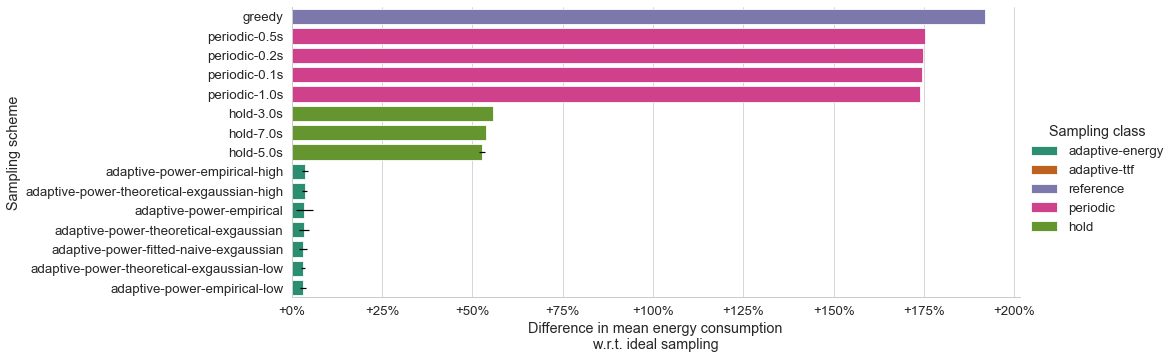

In [20]:
import matplotlib.ticker as tkr

plot_data = energies_maxrtt.reset_index().query("sampling_scheme != 'ideal'")

fg = sns.catplot(
    kind="bar",
    errorbar=None,
    data=plot_data,
    y="sampling_scheme",
    x="mean_diff_ideal_percent",
    aspect=3,
    xerr=plot_data["mean_diff_ideal_95ci_percent"],
    order=plot_data.sort_values("mean_diff_ideal", ascending=False)["sampling_scheme"],
    hue="sampling_class",
    dodge=False,
)
for ax in fg.axes.flat:
    # pass
    # ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=55, ha="right", rotation_mode="anchor")
    ax.xaxis.set_major_formatter(tkr.FuncFormatter(lambda y, p: f"{y:+0.0%}"))

fg.set_axis_labels("Difference in mean energy consumption\nw.r.t. ideal sampling", "Sampling scheme")
fg.legend.set_title("Sampling class")
plt.show()

In [21]:
best_schemes = plot_data.sort_values("mean_diff_ideal", ascending=False)["sampling_scheme"][-5:]
best_schemes

0                     adaptive-power-empirical
3        adaptive-power-theoretical-exgaussian
6       adaptive-power-fitted-naive-exgaussian
4    adaptive-power-theoretical-exgaussian-low
1                 adaptive-power-empirical-low
Name: sampling_scheme, dtype: category
Categories (16, object): ['greedy' < 'ideal' < 'adaptive-power-empirical' < 'adaptive-power-empirical-low' ... 'periodic-1.0s' < 'hold-3.0s' < 'hold-5.0s' < 'hold-7.0s']

In [22]:
results_best = results_per_rep[np.isin(results_per_rep["sampling_scheme"], best_schemes)].copy()
results_best["sampling_scheme"] = results_best["sampling_scheme"].cat.remove_unused_categories()
results_best

,timing_model,sampling_scheme,sampling_class,rtt,repetition,execution_time,step_duration,ttf,wait_time,samples,energy,idle_energy,comm_energy,idle_time,comm_time,success_sample_instant
1200,empirical-high,adaptive-power-empirical,adaptive-energy,0.5,1,7.391284,20.672043,13.280759,12.780759,1.058333,1.259406,0.306906,0.9525,20.460376,0.211667,20.172043
1201,empirical-high,adaptive-power-empirical,adaptive-energy,0.5,2,6.905321,20.142695,13.237374,12.737374,1.008333,1.206615,0.299115,0.9075,19.941028,0.201667,19.642695
1202,empirical-high,adaptive-power-empirical,adaptive-energy,0.5,3,7.247644,20.297397,13.049753,12.549753,1.041667,1.238836,0.301336,0.9375,20.089064,0.208333,19.797397
1203,empirical-high,adaptive-power-empirical,adaptive-energy,0.5,4,6.659824,20.333933,13.674109,13.174109,1.016667,1.216959,0.301959,0.9150,20.130599,0.203333,19.833933
1204,empirical-high,adaptive-power-empirical,adaptive-energy,0.5,5,7.395908,20.138123,12.742216,12.242216,1.025000,1.221497,0.298997,0.9225,19.933123,0.205000,19.638123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5395,empirical-high,adaptive-power-fitted-naive-exgaussian,adaptive-energy,5.0,56,6.125288,56.611171,50.485883,45.485883,1.000000,21.928668,0.778668,21.1500,51.911171,4.700000,51.611171
5396,empirical-high,adaptive-power-fitted-naive-exgaussian,adaptive-energy,5.0,57,7.501022,56.611171,49.110149,44.110149,1.000000,21.928668,0.778668,21.1500,51.911171,4.700000,51.611171
5397,empirical-high,adaptive-power-fitted-naive-exgaussian,adaptive-energy,5.0,58,7.497036,56.611171,49.114135,44.114135,1.000000,21.928668,0.778668,21.1500,51.911171,4.700000,51.611171
5398,empirical-high,adaptive-power-fitted-naive-exgaussian,adaptive-energy,5.0,59,7.765548,56.611171,48.845623,43.845623,1.000000,21.928668,0.778668,21.1500,51.911171,4.700000,51.611171


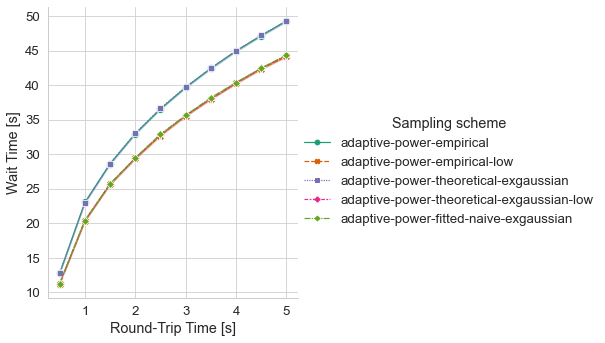

In [23]:
fg = sns.relplot(
    kind="line",
    errorbar=("ci", 95),
    data=results_best,
    x="rtt",
    y="wait_time",
    hue="sampling_scheme",
    style="sampling_scheme",
    markers=True,
    markersize=8,
)
fg.set_axis_labels("Round-Trip Time [s]", "Wait Time [s]")
fg.legend.set_title("Sampling scheme")
plt.show()